# Reduced-Basis Derivative-Informed Neural Operators (RB-DINO): Tutorial

This notebook walks through the full RB-DINO workflow for a nonlinear hyperelasticity inverse problem:

1. **Problem setup** — formulate the Bayesian inverse problem with a FEniCS/hippylib PDE model
2. **Visualize the forward map** — sample parameter fields from the prior, solve the PDE, and inspect observations
3. **Generate training data** — solve many PDEs in parallel and build derivative-informed reduced bases
4. **Inspect the reduced bases** — verify that the encoder/decoder basis functions capture the dominant modes
5. **Train the neural operator** — learn the reduced-basis parameter-to-observable map with an Equinox MLP
6. **Evaluate accuracy** — compare DINO surrogate predictions against true PDE solves

> **Prerequisites:** This notebook requires a conda environment with FEniCS 2019.1 and GPU-enabled JAX. See the [README](https://github.com/dinoSciML/dinox) for installation instructions.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from pathlib import Path
top_level_save_path = Path("/storage/joshua/ThursdayFeb19")  # pick a save path "/pick/a/path/to/save/files/in"

---
## 1. Problem Formulation

We begin by examining the PDE inverse problem that the neural operator will learn to emulate. The goal is to infer a spatially varying material stiffness field from noisy displacement observations of a stretched elastic body.

### Hyperelasticity Inverse Problem: Mathematical Formulation

#### Parameter Field

The unknown is a spatially varying Young's modulus $E(\mathbf{x})$. Rather than parameterizing $E$ directly, we work with an auxiliary Gaussian random field $m(\mathbf{x})$ on $\Omega = [0, 2] \times [0, 1]$.

**Prior.** The field $m$ is endowed with a BiLaplacian (Matérn-like) Gaussian prior,

$$m \sim \mathcal{N}(\mathbf{0},\, \mathcal{C}_{\mathrm{prior}}), \qquad \mathcal{C}_{\mathrm{prior}}^{-1} = \delta\,(-\gamma \nabla \cdot (\Theta\,\nabla) + \delta\,I)^2,$$

where $\gamma$ and $\delta$ are set by a pointwise standard deviation $\sigma$ and correlation length $\rho$:

$$\delta = \frac{1}{\sigma\,\rho}, \qquad \gamma = \delta\,\rho^2.$$

The anisotropy tensor $\Theta$ has eigenvalues $\theta_0 = 2.0$, $\theta_1 = 0.5$ and rotation angle $\alpha = \arctan(2)$, producing elongated correlation along the domain diagonal.

**Parameter-to-modulus map.** To ensure $E > 0$, we use

$$E(m) = 3\bigl(\operatorname{erf}(m) + 1\bigr) + 1, \qquad E \in (1, 7).$$

#### Forward PDE: Finite-Strain Hyperelasticity

Given $E(\mathbf{x})$, we solve for the displacement $\mathbf{u}: \Omega \to \mathbb{R}^2$. With deformation gradient $\mathbf{F} = \mathbf{I} + \nabla \mathbf{u}$ and right Cauchy–Green tensor $\mathbf{C} = \mathbf{F}^\top \mathbf{F}$, the compressible Neo-Hookean stored energy is

$$\psi(\mathbf{u}, m) = \frac{\mu}{2}(\operatorname{tr}\mathbf{C} - 3) - \mu \ln J + \frac{\lambda}{2}(\ln J)^2, \qquad J = \det \mathbf{F},$$

with Lamé parameters $\mu = E / [2(1+\nu)]$, $\lambda = E\nu / [(1+\nu)(1-2\nu)]$, and $\nu = 0.4$.

**Boundary conditions:**
- Left ($x_1 = 0$): clamped, $\mathbf{u} = \mathbf{0}$
- Right ($x_1 = 2$): prescribed stretch, $\mathbf{u} = (1.5, 0)$ — a 75% extension

#### Observation Model

Displacement is observed at $n_{\text{obs}} = 288$ uniformly spaced interior points via the operator $\mathbf{B}: V_h \to \mathbb{R}^{576}$:

$$\mathbf{d} = \mathbf{B}\,\mathbf{u}(m^{\dagger}) + \boldsymbol{\eta}, \qquad \boldsymbol{\eta} \sim \mathcal{N}(\mathbf{0},\, \sigma_{\text{noise}}^2\,\mathbf{I}), \quad \sigma_{\text{noise}}^2 = 0.02.$$

#### The Bayesian Inverse Problem

$$\pi(m \mid \mathbf{d}) \propto \exp\!\Bigl(-\frac{1}{2\sigma_{\text{noise}}^2}\|\mathbf{B}\mathbf{u}(m) - \mathbf{d}\|^2\Bigr)\;\pi_{\text{prior}}(m).$$

The map $m \mapsto \mathbf{B}\mathbf{u}(m)$ is nonlinear (through both the $\operatorname{erf}$ transform and the finite-strain PDE), making this a challenging inference problem — and a good candidate for neural operator surrogates.

---
## 2. Visualize the Forward Map

To build intuition, we draw three random samples $m_1, m_2, m_3$ from the prior, solve the forward PDE for each, and display:

- **Left:** the parameter random field $m_i(\mathbf{x})$
- **Top right:** the displacement magnitude $|\mathbf{u}_i|$ on the deformed (Lagrangian) configuration
- **Bottom right:** noisy observation magnitudes $|\mathbf{d}_i|$ on the reference (Eulerian) configuration

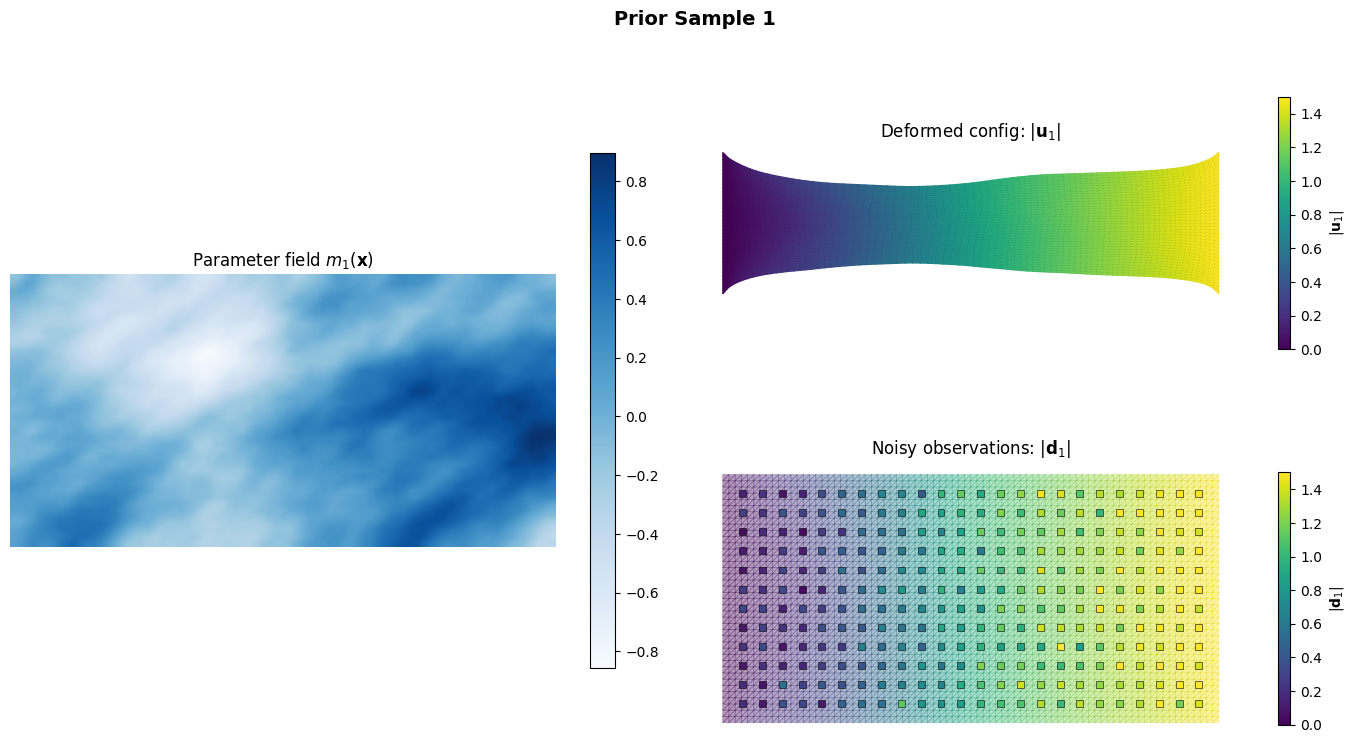

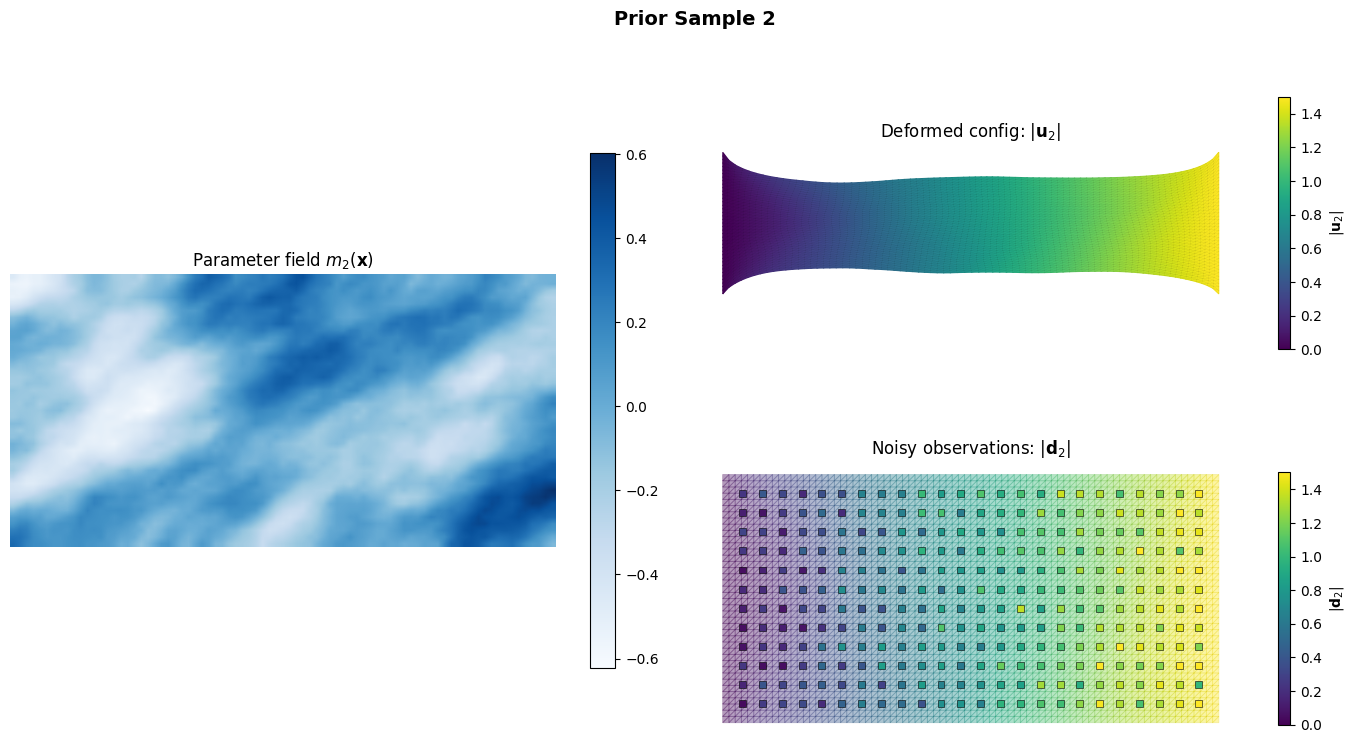

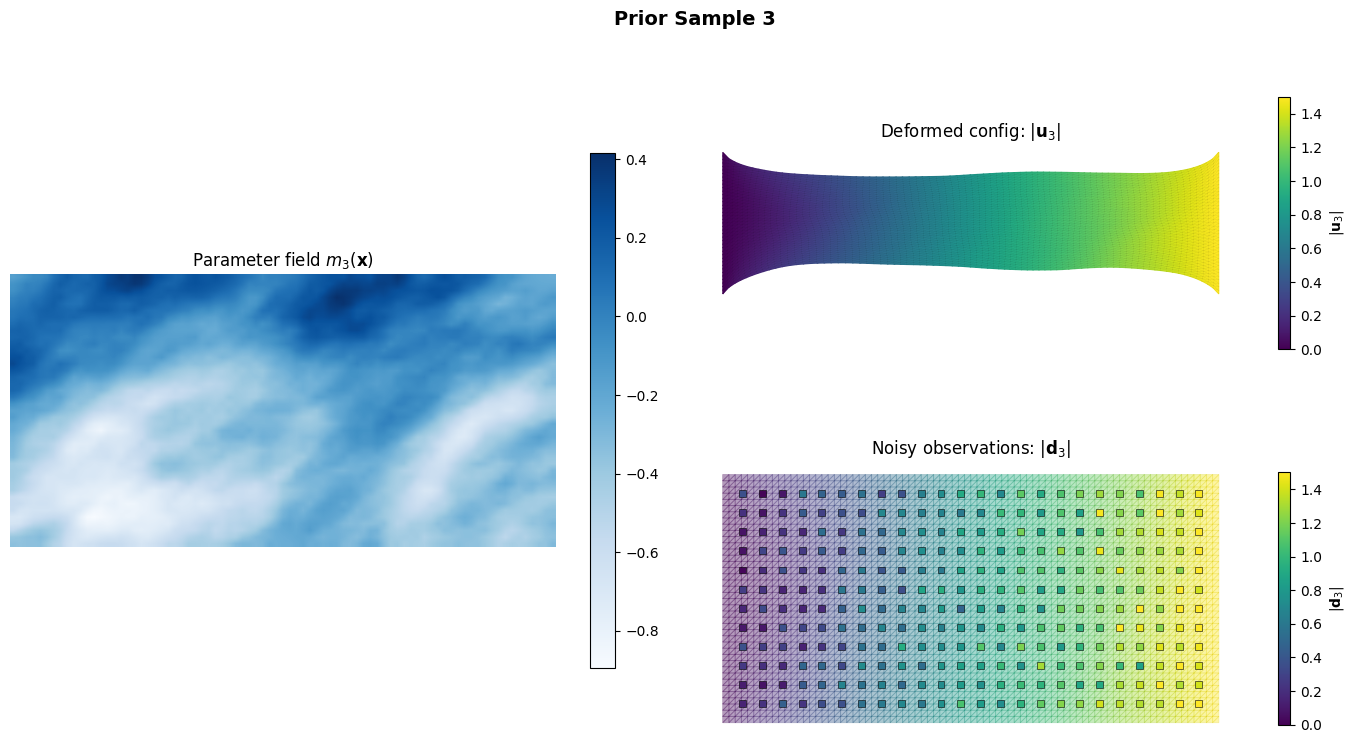

In [2]:
hippylib_model = "hyperelasticity"
model_name = hippylib_model + ".model"

import importlib
import numpy as np
import dolfin as dl
import hippylib as hp
import matplotlib.pyplot as plt
import matplotlib.tri as tri

STATE, PARAMETER = 0, 1

model_module = importlib.import_module(model_name)
s = model_module.settings()
hp_model = model_module.model(s)

prior = hp_model.prior
misfit = hp_model.misfit
pde = hp_model.problem
mesh = pde.Vh[STATE].mesh()

# Parameter DOF coordinates for reshaping to grid
coords_param = pde.Vh[PARAMETER].tabulate_dof_coordinates().reshape((-1, 2))
reshaper = np.lexsort((coords_param[:, 0], coords_param[:, 1]))
x_unique = np.unique(coords_param[:, 0])
y_unique = np.unique(coords_param[:, 1])
ny, nx = len(y_unique), len(x_unique)

# Mesh triangulation for plotting vector state fields
mesh_coords = mesh.coordinates()
cells = mesh.cells()
n_vertices = mesh.num_vertices()
triang = tri.Triangulation(mesh_coords[:, 0], mesh_coords[:, 1], cells)

# Observation targets
targets = s["targets"]
noise_std = np.sqrt(s["noise_variance"])

n_samples = 3

for i in range(1, n_samples + 1):
    # ── Sample from prior ──
    noise_vec = dl.Vector()
    prior.init_vector(noise_vec, "noise")
    hp.parRandom.normal(1.0, noise_vec)

    m = hp_model.generate_vector(PARAMETER)
    prior.sample(noise_vec, m)
    m_array = m.get_local()

    # ── Solve forward problem ──
    x = hp_model.generate_vector()
    x[PARAMETER].axpy(1.0, m)
    pde.solveFwd(x[STATE], x)

    # ── Extract state on mesh vertices ──
    u_func = hp.vector2Function(x[STATE], pde.Vh[STATE])
    u_array = u_func.compute_vertex_values(mesh)
    ux = u_array[:n_vertices]
    uy = u_array[n_vertices:]
    u_mag = np.sqrt(ux**2 + uy**2)

    # ── Deformed triangulation ──
    deformed_coords = mesh_coords.copy()
    deformed_coords[:, 0] += ux
    deformed_coords[:, 1] += uy
    triang_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], cells)

    # ── Noisy observations ──
    Bu = dl.Vector()
    misfit.B.init_vector(Bu, 0)
    misfit.B.mult(x[STATE], Bu)
    obs_clean = Bu.get_local()
    obs_noisy = obs_clean + noise_std * np.random.randn(len(obs_clean))

    obs_ux = obs_noisy[0::2]
    obs_uy = obs_noisy[1::2]
    obs_mag = np.sqrt(obs_ux**2 + obs_uy**2)

    # ── Plot ──
    fig = plt.figure(figsize=(14, 8))
    fig.suptitle(f'Prior Sample {i}', fontsize=14, fontweight='bold')

    ax_param = fig.add_subplot(1, 2, 1)
    ax_deformed = fig.add_subplot(2, 2, 2)
    ax_obs = fig.add_subplot(2, 2, 4)

    # Parameter field
    im0 = ax_param.imshow(
        m_array[reshaper].reshape((ny, nx)),
        extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
        origin='lower',
        interpolation='bilinear',
        cmap='Blues',
        aspect='equal'
    )
    ax_param.set_title(f'Parameter field $m_{{{i}}}(\\mathbf{{x}})$')
    ax_param.axis('off')
    plt.colorbar(im0, ax=ax_param, shrink=0.7)

    # Deformed configuration (Lagrangian)
    tc = ax_deformed.tripcolor(triang_def, u_mag, shading='gouraud', cmap='viridis')
    ax_deformed.triplot(triang_def, color='k', linewidth=0.15, alpha=0.15)
    ax_deformed.set_title(f'Deformed config: $|\\mathbf{{u}}_{{{i}}}|$')
    ax_deformed.set_aspect('equal')
    ax_deformed.axis('off')
    plt.colorbar(tc, ax=ax_deformed, shrink=0.7, label=f'$|\\mathbf{{u}}_{{{i}}}|$')

    # Noisy observations on reference (Eulerian) configuration
    tc2 = ax_obs.tripcolor(triang, u_mag, shading='gouraud', cmap='viridis', alpha=0.4)
    ax_obs.triplot(triang, color='k', linewidth=0.15, alpha=0.1)
    sc = ax_obs.scatter(
        targets[:, 0], targets[:, 1],
        c=obs_mag,
        s=25,
        marker='s',
        cmap='viridis',
        vmin=tc.get_clim()[0],
        vmax=tc.get_clim()[1],
        edgecolors='k',
        linewidths=0.4,
        zorder=5
    )
    ax_obs.set_title(f'Noisy observations: $|\\mathbf{{d}}_{{{i}}}|$')
    ax_obs.set_aspect('equal')
    ax_obs.axis('off')
    plt.colorbar(sc, ax=ax_obs, shrink=0.7, label=f'$|\\mathbf{{d}}_{{{i}}}|$')

    plt.tight_layout()
    plt.show()

---
## 3. Generate Training Data and Build Reduced Bases

We now solve the PDE for many parameter samples (in parallel) to generate training data. Simultaneously, `dinox` computes **derivative-informed reduced bases** — low-rank subspaces constructed from Jacobian information of the parameter-to-observable map. These bases compress the high-dimensional parameter and observable spaces to dimensions where a neural network can efficiently learn the map.

> **Note:** This cell uses multiprocessing to run independent FEniCS PDE solves concurrently. Adjust `N_processes` based on your machine's CPU cores.

In [3]:
# Set up concurrent single-thread PDE solves with hippylib/FEniCS
import os
os.environ["PYTHONWARNINGS"] = "ignore"
for var in (
    'OMP_NUM_THREADS',
    'OPENBLAS_NUM_THREADS',
    'MKL_NUM_THREADS',
    'VECLIB_MAXIMUM_THREADS',
    'NUMEXPR_NUM_THREADS',
):
    os.environ[var] = '1'
import multiprocessing as mp
mp.set_start_method('spawn', force=True)
from pathlib import Path


N_processes = 50  # number of concurrent PDE solves

# Problem configuration
input_dims = [200]  # reduced input dimension
N_trains = [50, 200, 800]  # training set sizes to compare
dimension_reduction_type = 'derivative_informed'
base_path = Path(top_level_save_path, hippylib_model)
data_path = Path(base_path, "pde_data")

# Generate reduced bases and latent training data
from dinox.data_generating import generate_latent_data_for_dino_training
generate_latent_data_for_dino_training(
    model_name=model_name,
    key=1,
    dimension_reduction_type=dimension_reduction_type,
    N_encodec_computation=10,  # must be >= max(N_trains)
    input_dims=input_dims,
    N_trains=N_trains,
    N_test=10,    # 10_000 for production
    N_val=10,     # 2_500 for production
    save_path=data_path,
    N_multiprocessing=N_processes
)

Generating data for derivative informed subspace detection
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started sampling...
		Started samplin

{(200,
  None): {'train': {'encoded_Jacobians': array([[[ 6.00036662e-03,  4.67924133e-03, -9.60830854e-04, ...,
            -1.71733466e-05, -1.55320276e-05, -7.29754634e-06],
           [ 9.92698412e-03,  6.46504021e-03, -1.60016603e-03, ...,
            -4.08317359e-06, -6.76505518e-06, -5.58766653e-06],
           [ 1.52524207e-02,  1.12911843e-02, -2.41447587e-03, ...,
             8.07821640e-06,  2.91822780e-05, -3.96073740e-06],
           ...,
           [ 1.51472785e-02, -6.99498262e-03, -5.97279072e-03, ...,
             2.10256669e-06, -6.64640269e-06, -6.51686580e-06],
           [ 7.26107337e-03, -3.77132826e-03, -2.72039947e-03, ...,
             1.24829510e-05,  3.06578877e-06,  3.11022633e-05],
           [ 9.60268073e-03, -5.10675219e-03, -3.51756115e-03, ...,
             1.01104885e-05,  5.22367838e-06,  2.67592934e-05]],
   
          [[ 6.60969642e-03,  4.23601162e-03, -7.49172365e-04, ...,
            -1.19265955e-05, -1.00810706e-05, -4.64421109e-06],
          

---
## 4. Inspect the Derivative-Informed Reduced Bases

The derivative-informed dimension reduction produces encoder/decoder pairs for the parameter space. The **encoder** projects a high-dimensional parameter field onto a low-dimensional coefficient vector, and the **decoder** reconstructs it.

Below we plot selected basis functions. Early modes (small index) capture the directions of greatest sensitivity — i.e., the parameter variations that most affect the observables. Later modes capture progressively finer details.

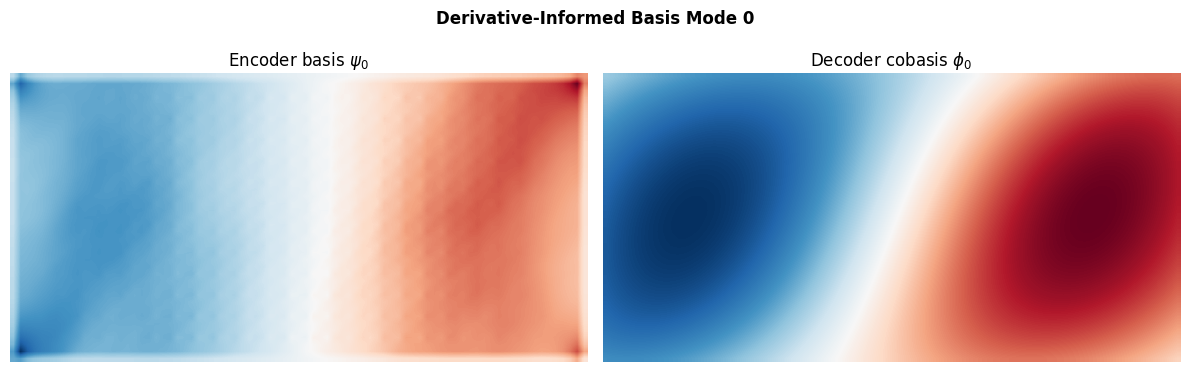

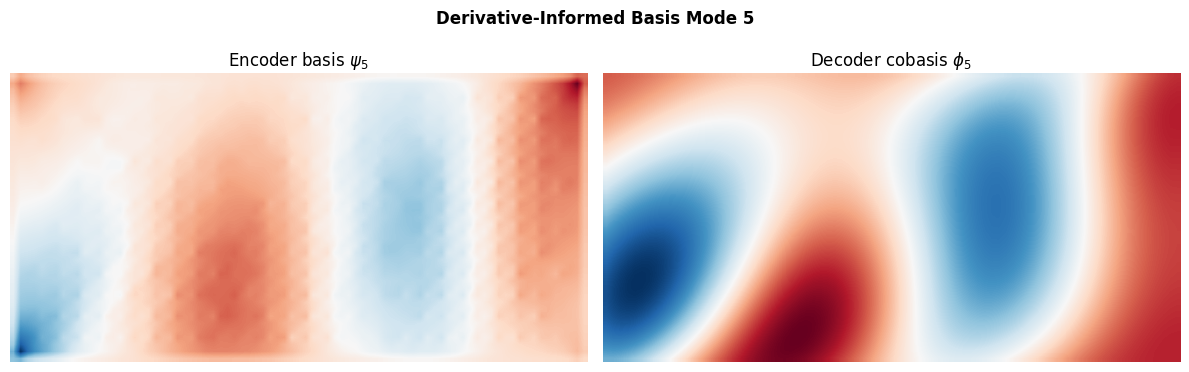

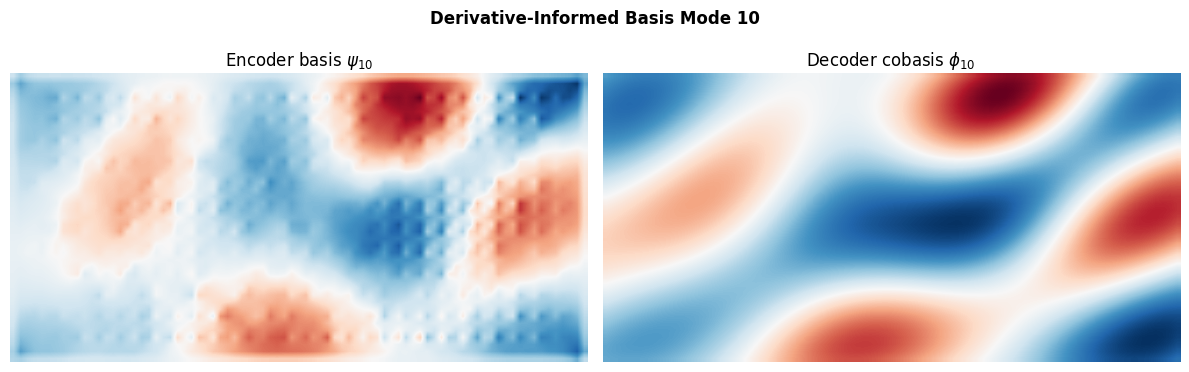

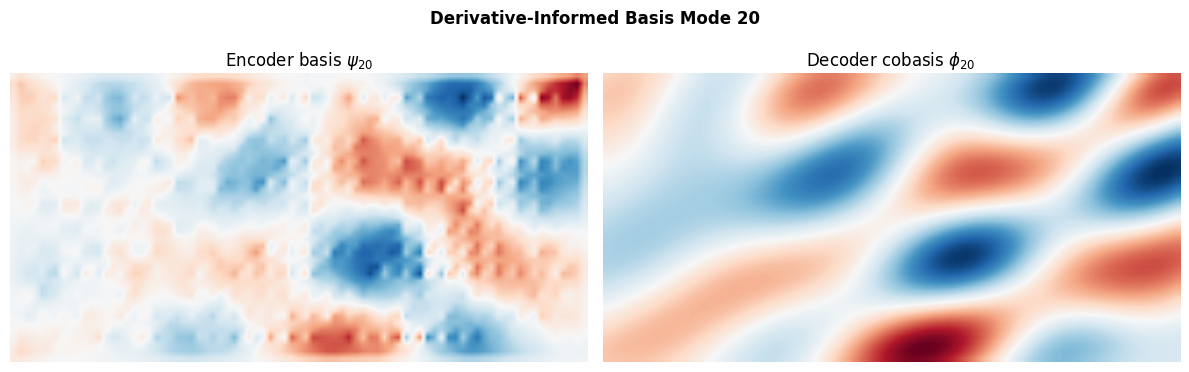

In [4]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
from dinox.data_loading import load_pytree_from_disk

model_module = importlib.import_module(model_name)
model = model_module.model(model_module.settings())
output_dimension = model_module.settings()['dQ']
coords = model.problem.Vh[1].tabulate_dof_coordinates().reshape((-1, 2))

x_unique = np.unique(coords[:, 0])
y_unique = np.unique(coords[:, 1])
nx, ny = len(x_unique), len(y_unique)
reshaper = np.lexsort((coords[:, 0], coords[:, 1]))

reduced_dim_pairs = [(input_dims[0], None)]
encodec_dict = load_pytree_from_disk(Path(data_path, dimension_reduction_type, "encodec_dict.hkl"))
encodec_dict = encodec_dict[reduced_dim_pairs[0]]

indices_to_plot = [0, 5, 10, 20]
for idx in indices_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(
        encodec_dict['input']['encoder'][:, idx][reshaper].reshape((ny, nx)),
        extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
        origin='lower',
        interpolation='bilinear',
        cmap='RdBu_r'
    )
    axes[0].set_title(f'Encoder basis $\\psi_{{{idx}}}$')
    axes[0].axis('off')

    axes[1].imshow(
        encodec_dict['input']['decoder'][:, idx][reshaper].reshape((ny, nx)),
        extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
        origin='lower',
        interpolation='bilinear',
        cmap='RdBu_r'
    )
    axes[1].set_title(f'Decoder cobasis $\\phi_{{{idx}}}$')
    axes[1].axis('off')

    plt.suptitle(f'Derivative-Informed Basis Mode {idx}', fontweight='bold')
    plt.tight_layout()
    plt.show()

---
## 5. Train the RB-DINO Surrogate

We train an Equinox MLP to approximate the reduced-basis parameter-to-observable map:

$$\hat{\mathbf{y}} = \mathbf{NN}_\theta(\mathbf{z}), \qquad \mathbf{z} = \Psi^\top m \in \mathbb{R}^{r_x},\quad \hat{\mathbf{y}} \in \mathbb{R}^{r_y},$$

where $\Psi$ is the encoder and $r_x = 200$ is the reduced input dimension.

We compare two loss functions:
- **L2 loss**  (L2NO in the LazyDINO paper) — trains on function values only
- **H1 loss**  (DINO in the LazyDINO paper)— additionally penalizes Jacobian errors, which is the key idea behind *derivative-informed* training

We sweep over training set sizes $N \in \{50, 200, 800\}$ to study data efficiency.

In [5]:
import gc
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from dinox.equinox_nn_factories import EquinoxMLPConfig, EquinoxMLPWrapper
from dinox.training_utils import load_encoded_data_train_and_test_dino

# Training hyperparameters
losses = ['L2', 'H1']
N_MAX_EPOCHS = 1500
STEP_SIZE = 3e-4
BATCH_SIZE = 25
OPTAX_OPTIMIZER_NAME = 'adam'
RANDOM_PERMUTATIONS_SEED = 0

EQX_CONFIG = {
    'random_initializer_key': 6,
    'activation_name': 'gelu',
    'depth': 6
}

training_results = dict()
for LOSS_NAME in losses:
    training_results[LOSS_NAME] = dict()
    for REDUCED_DIMS in reduced_dim_pairs:
        training_results[LOSS_NAME][REDUCED_DIMS] = dict()
        for N_TRAIN in N_trains:
            EQX_CONFIG['input_dimension'] = REDUCED_DIMS[0]
            EQX_CONFIG['output_dimension'] = REDUCED_DIMS[1] if REDUCED_DIMS[1] is not None else output_dimension
            EQX_CONFIG['layer_width'] = 250 + EQX_CONFIG['input_dimension']

            EQX_PATH = Path(data_path, dimension_reduction_type, 'eqx',
                            f'{LOSS_NAME}_{REDUCED_DIMS}_{N_TRAIN}')
            eqx_mlp_wrapper = EquinoxMLPWrapper(
                eqx_config=EquinoxMLPConfig(**EQX_CONFIG), path=EQX_PATH
            )

            print(f"Loss: {LOSS_NAME}, N_train: {N_TRAIN}, "
                  f"dims: ({EQX_CONFIG['input_dimension']}, {EQX_CONFIG['output_dimension']})")

            eqx_mlp_wrapper, training_results[LOSS_NAME][REDUCED_DIMS][N_TRAIN] = \
                load_encoded_data_train_and_test_dino(
                    eqx_wrapper=eqx_mlp_wrapper,
                    data_path=Path(data_path, dimension_reduction_type),
                    LOSS_NAME=LOSS_NAME,
                    N_MAX_EPOCHS=N_MAX_EPOCHS,
                    STEP_SIZE=STEP_SIZE,
                    BATCH_SIZE=BATCH_SIZE,
                    OPTAX_OPTIMIZER_NAME=OPTAX_OPTIMIZER_NAME,
                    N_TRAIN=N_TRAIN,
                    REDUCED_DIMS=REDUCED_DIMS,
                    RANDOM_PERMUTATIONS_SEED=RANDOM_PERMUTATIONS_SEED
                )
            eqx_mlp_wrapper.model_dump()

            res = training_results[LOSS_NAME][REDUCED_DIMS][N_TRAIN]
            print(f"  Rel. L2 error: {100*res['test_errors'][2]:.2f}%  "
                  f"Rel. H1 error: {100*res['test_errors'][3]:.2f}%")
            
            del eqx_mlp_wrapper, res
            gc.collect()

Building new eqx MLP from scratch
Loss: L2, N_train: 50, dims: (200, 576)
Started training...
Iter: 100,  computing validation errors
val errors (Array(1.9935308, dtype=float64), Array(0.12924337, dtype=float64))
train_errors (Array(0.70847921, dtype=float64), Array(0.04791864, dtype=float64))
Iter: 200,  computing validation errors
val errors (Array(1.96715366, dtype=float64), Array(0.12751086, dtype=float64))
train_errors (Array(0.41762489, dtype=float64), Array(0.02824822, dtype=float64))
Iter: 300,  computing validation errors
val errors (Array(1.96390851, dtype=float64), Array(0.12732175, dtype=float64))
train_errors (Array(0.31955444, dtype=float64), Array(0.02167861, dtype=float64))
Iter: 400,  computing validation errors
val errors (Array(1.96285719, dtype=float64), Array(0.12724953, dtype=float64))
train_errors (Array(0.24835514, dtype=float64), Array(0.01686184, dtype=float64))
Iter: 500,  computing validation errors
val errors (Array(1.96511282, dtype=float64), Array(0.12737

---
## 6. Surrogate Accuracy: Test Errors vs. Training Set Size

We plot the relative $L^2$ and $H^1$ test errors as a function of training set size. The H1-trained DINO should show substantially better Jacobian accuracy, which is critical for downstream inference tasks like MCMC or optimization.

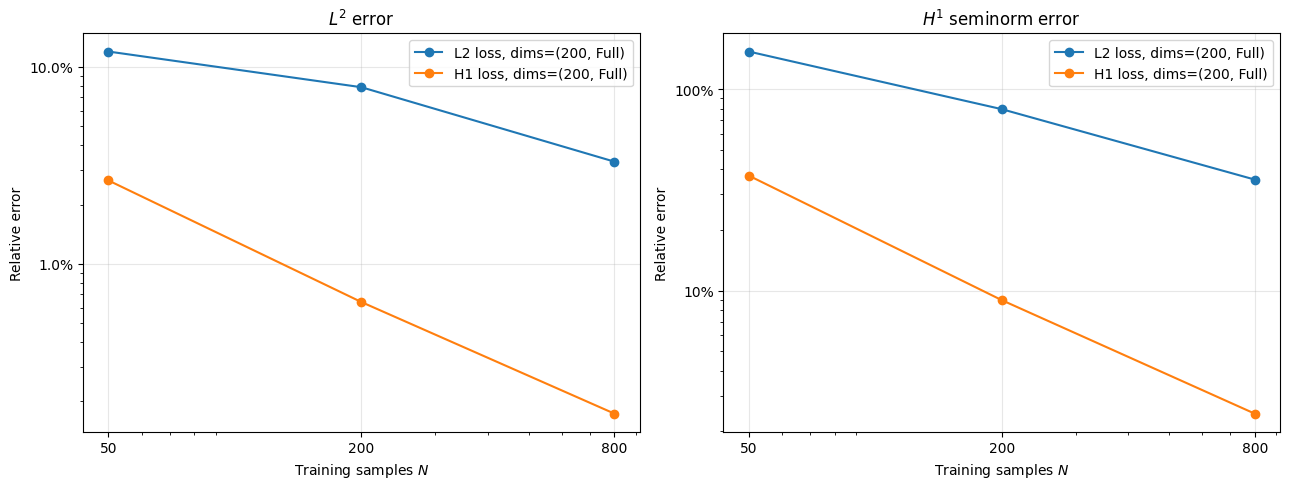

In [6]:
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# ── Left: L2 errors ──
ax = axes[0]
for LOSS_NAME in losses:
    for REDUCED_DIMS in reduced_dim_pairs:
        dims_label = f"({REDUCED_DIMS[0]}, Full)" if REDUCED_DIMS[1] is None else str(REDUCED_DIMS)
        L2errors = [training_results[LOSS_NAME][REDUCED_DIMS][k]['test_errors'][2] for k in N_trains]
        ax.loglog(N_trains, L2errors, marker='o', label=f'{LOSS_NAME} loss, dims={dims_label}')
ax.set_xlabel("Training samples $N$")
ax.set_ylabel("Relative error")
ax.set_title("$L^2$ error")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks(N_trains)
ax.legend()
ax.grid(True, alpha=0.3)

# ── Right: H1 errors ──
ax = axes[1]
for LOSS_NAME in losses:
    for REDUCED_DIMS in reduced_dim_pairs:
        dims_label = f"({REDUCED_DIMS[0]}, Full)" if REDUCED_DIMS[1] is None else str(REDUCED_DIMS)
        H1errors = [training_results[LOSS_NAME][REDUCED_DIMS][k]['test_errors'][3] for k in N_trains]
        ax.loglog(N_trains, H1errors, marker='o', label=f'{LOSS_NAME} loss, dims={dims_label}')
ax.set_xlabel("Training samples $N$")
ax.set_ylabel("Relative error")
ax.set_title("$H^1$ seminorm error")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks(N_trains)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 7. Compare DINO Predictions with True PDE Observables

Finally, we evaluate the trained DINO surrogate on test parameter samples and compare its predictions against the true PDE-computed observables.

For each test sample we show two comparisons:

- **True vs. DINO observables** — the noise-free output of the PDE versus the neural operator prediction. This measures the *surrogate approximation error*.
- **Synthetic noisy observations** — we add the *same* noise realization $\boldsymbol{\eta}$ to both the true and DINO observables. This simulates what a downstream inference algorithm (e.g., MCMC) would see. If the DINO is accurate, the two noisy observation vectors should be nearly indistinguishable — meaning the surrogate-driven posterior is a good approximation to the true posterior.

Loading config from file
Loading eqx MLP from file


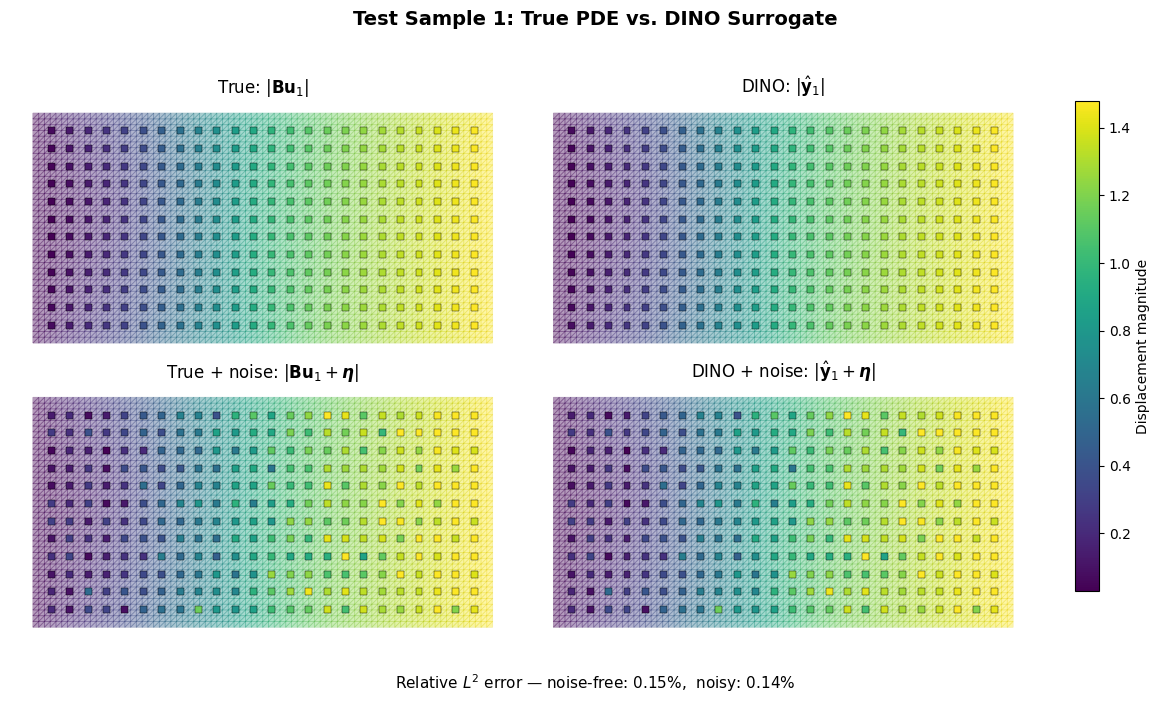

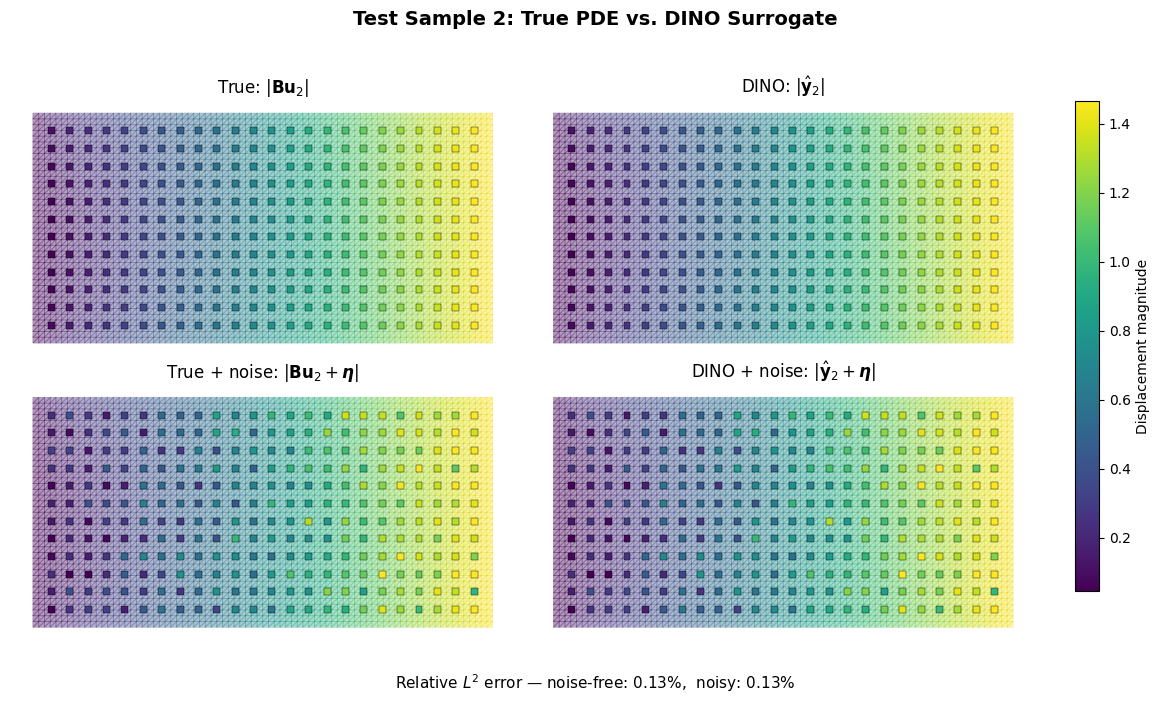

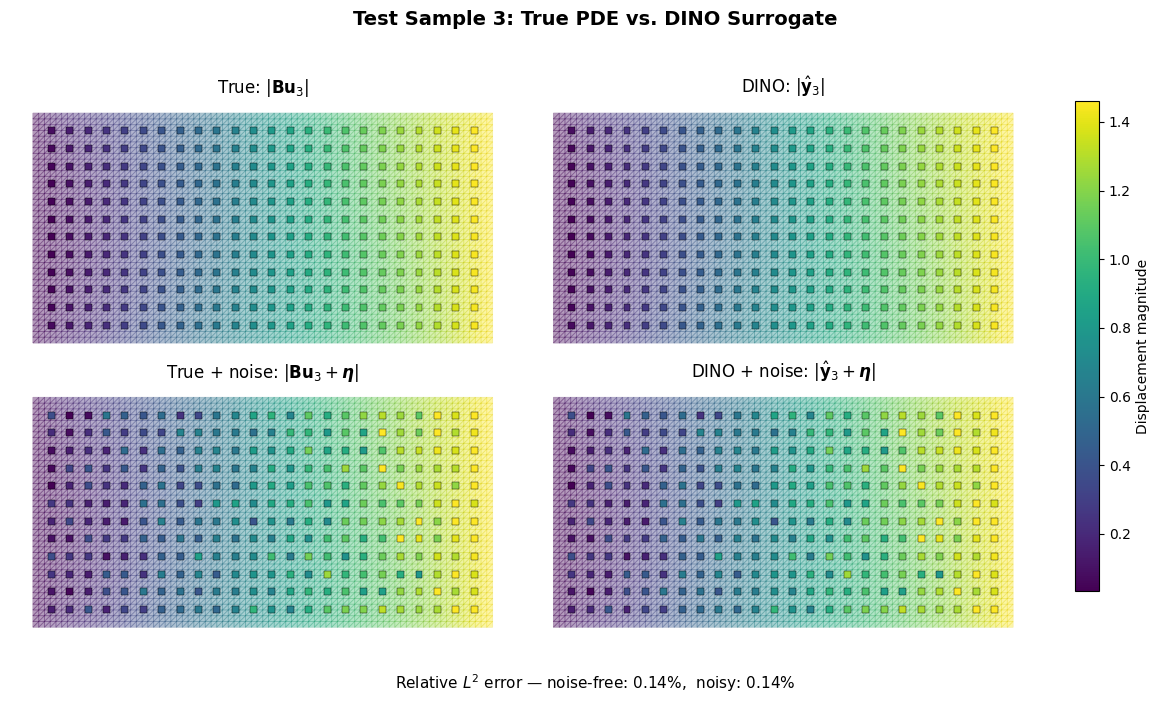

In [7]:
# Load the best trained model (H1 loss, largest training set)
BEST_LOSS = 'H1'
BEST_N_TRAIN = max(N_trains)
BEST_REDUCED_DIMS = reduced_dim_pairs[0]

EQX_CONFIG['input_dimension'] = BEST_REDUCED_DIMS[0]
EQX_CONFIG['output_dimension'] = BEST_REDUCED_DIMS[1] if BEST_REDUCED_DIMS[1] is not None else output_dimension
EQX_CONFIG['layer_width'] = 250 + EQX_CONFIG['input_dimension']

EQX_PATH = Path(data_path, dimension_reduction_type, 'eqx',
                f'{BEST_LOSS}_{BEST_REDUCED_DIMS}_{BEST_N_TRAIN}')
eqx_mlp_wrapper = EquinoxMLPWrapper(path=EQX_PATH, load_from_file=True)

# Load the encoder for projecting parameters into the reduced space
import jax.numpy as jnp
encoder = encodec_dict['input']['encoder']  # shape: (n_dofs, r_x)

n_compare = 3

for i in range(1, n_compare + 1):
    # ── Draw a fresh prior sample ──
    noise_vec = dl.Vector()
    prior.init_vector(noise_vec, "noise")
    hp.parRandom.normal(1.0, noise_vec)

    m_vec = hp_model.generate_vector(PARAMETER)
    prior.sample(noise_vec, m_vec)
    m_array = m_vec.get_local()

    # ── True PDE solve ──
    x = hp_model.generate_vector()
    x[PARAMETER].axpy(1.0, m_vec)
    pde.solveFwd(x[STATE], x)

    # ── Extract state on mesh vertices (for background field) ──
    u_func = hp.vector2Function(x[STATE], pde.Vh[STATE])
    u_array = u_func.compute_vertex_values(mesh)
    ux = u_array[:n_vertices]
    uy = u_array[n_vertices:]
    u_mag = np.sqrt(ux**2 + uy**2)

    Bu_true = dl.Vector()
    misfit.B.init_vector(Bu_true, 0)
    misfit.B.mult(x[STATE], Bu_true)
    obs_true = Bu_true.get_local()

    # ── DINO prediction ──
    z = jnp.array(encoder.T @ m_array)  # encode: (r_x,)
    obs_dino = np.array(eqx_mlp_wrapper.nn(z))  # predict observables

    # ── Shared noise realization ──
    eta = noise_std * np.random.randn(len(obs_true))
    obs_true_noisy = obs_true + eta
    obs_dino_noisy = obs_dino + eta

    # Compute magnitudes (interleaved ux, uy)
    true_mag = np.sqrt(obs_true[0::2]**2 + obs_true[1::2]**2)
    dino_mag = np.sqrt(obs_dino[0::2]**2 + obs_dino[1::2]**2)
    true_noisy_mag = np.sqrt(obs_true_noisy[0::2]**2 + obs_true_noisy[1::2]**2)
    dino_noisy_mag = np.sqrt(obs_dino_noisy[0::2]**2 + obs_dino_noisy[1::2]**2)

    vmin = min(true_mag.min(), dino_mag.min())
    vmax = max(true_mag.max(), dino_mag.max())

    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    fig.suptitle(f'Test Sample {i}: True PDE vs. DINO Surrogate', fontsize=14, fontweight='bold')

    scatter_kw = dict(s=25, marker='s', cmap='viridis', vmin=vmin, vmax=vmax,
                      edgecolors='k', linewidths=0.3, zorder=5)

    # Draw Eulerian reference field behind each panel
    for ax in axes.flat:
        ax.tripcolor(triang, u_mag, shading='gouraud', cmap='viridis', alpha=0.4)
        ax.triplot(triang, color='k', linewidth=0.15, alpha=0.1)
        ax.set_aspect('equal')
        ax.axis('off')

    # Top left: true observables (noise-free)
    axes[0, 0].scatter(targets[:, 0], targets[:, 1], c=true_mag, **scatter_kw)
    axes[0, 0].set_title(f'True: $|\\mathbf{{B}}\\mathbf{{u}}_{{{i}}}|$')

    # Top right: DINO observables (noise-free)
    axes[0, 1].scatter(targets[:, 0], targets[:, 1], c=dino_mag, **scatter_kw)
    axes[0, 1].set_title(f'DINO: $|\\hat{{\\mathbf{{y}}}}_{{{i}}}|$')

    # Bottom left: true + noise
    axes[1, 0].scatter(targets[:, 0], targets[:, 1], c=true_noisy_mag, **scatter_kw)
    axes[1, 0].set_title(f'True + noise: $|\\mathbf{{B}}\\mathbf{{u}}_{{{i}}} + \\boldsymbol{{\\eta}}|$')

    # Bottom right: DINO + same noise
    sc = axes[1, 1].scatter(targets[:, 0], targets[:, 1], c=dino_noisy_mag, **scatter_kw)
    axes[1, 1].set_title(f'DINO + noise: $|\\hat{{\\mathbf{{y}}}}_{{{i}}} + \\boldsymbol{{\\eta}}|$')

    # Single shared colorbar on the right
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    fig.colorbar(sc, cax=cbar_ax, label='Displacement magnitude')

    # Relative errors
    rel_err = np.linalg.norm(obs_true - obs_dino) / np.linalg.norm(obs_true)
    rel_err_noisy = np.linalg.norm(obs_true_noisy - obs_dino_noisy) / np.linalg.norm(obs_true_noisy)
    fig.text(0.5, 0.01,
             f'Relative $L^2$ error — noise-free: {100*rel_err:.2f}%,  noisy: {100*rel_err_noisy:.2f}%',
             ha='center', fontsize=11)

    plt.tight_layout(rect=[0, 0.04, 0.88, 0.95])
    plt.show()

---
## Summary

This tutorial demonstrated the full RB-DINO pipeline:

1. We formulated a nonlinear Bayesian inverse problem for hyperelasticity with a spatially varying Young's modulus
2. We generated PDE training data and constructed **derivative-informed reduced bases** that capture the most observation-sensitive directions in parameter space
3. We trained Equinox MLPs with both $L^2$ and $H^1$ losses, showing that **derivative-informed (H1) training yields substantially better Jacobian accuracy**
4. We verified that the DINO surrogate produces observables nearly indistinguishable from true PDE solves — even after adding observation noise

The trained surrogate can now replace expensive PDE solves in downstream tasks such as MCMC sampling, MAP estimation, or optimal experimental design, with orders-of-magnitude speedup.